In [1]:
import matplotlib
%matplotlib inline

import sys

sys.path.append("../image")
import krige

sys.path.append("../radar")
import pyart_utils as pu


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
import pandas as pd

In [3]:
import glob

night = "2017-09-30"
next_night = "2017-10-01"
light_levels_files = glob.glob("../image/kriged/{}/*.csv".format(night))
def process_light_csv(fname):
    df = pd.read_csv(fname)
    df["timestamp"] = pd.to_datetime(fname.split("/")[-1].split(".")[-2])
    return df
light_levels = pd.concat((process_light_csv(f) for f in light_levels_files), ignore_index=True)

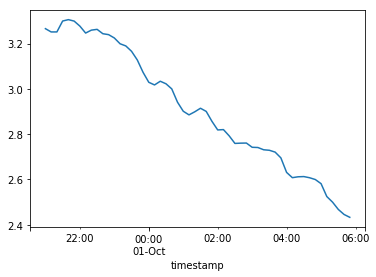

In [4]:
light_levels.groupby("timestamp").z.mean().plot()

In [5]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

In [6]:
import glob
radar_dir = "-".join(night.split("-")[:2]) + "/" + night.split("-")[-1]
next_radar_dir = "-".join(next_night.split("-")[:2]) + "/" + next_night.split("-")[-1]
print(radar_dir, next_radar_dir)
fnames = glob.glob("../radar/data/{}/*.filtered.csv".format(radar_dir))\
       + glob.glob("../radar/data/{}/*.filtered.csv".format(next_radar_dir))
og_radar_levels = pd.concat((process_radar_csv(fname)\
                          for fname in fnames))

t_filt = (og_radar_levels.Date_Time >= "{} 21:00".format(night)) &\
         (og_radar_levels.Date_Time <= "{} 06:00".format(next_night))
og_radar_levels = og_radar_levels[t_filt]

2017-09/30 2017-10/01


In [7]:
grouped = og_radar_levels.groupby(["lon", "lat"])
radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                   .reset_index()

In [8]:
radar_levels.head()

,lon,lat,level_2,Date_Time,dbzh
0,-74.02371,40.766165,0,2017-09-30 21:00:00,0.0
1,-74.02371,40.766165,1,2017-09-30 21:10:00,0.0
2,-74.02371,40.766165,2,2017-09-30 21:20:00,0.0
3,-74.02371,40.766165,3,2017-09-30 21:30:00,0.0
4,-74.02371,40.766165,4,2017-09-30 21:40:00,0.0


In [9]:
light_levels.head()

,Unnamed: 0,x,y,z,timestamp
0,0,-74.022494,40.696417,4.489848,2017-09-30 21:00:00
1,1,-74.021283,40.696429,4.427961,2017-09-30 21:00:00
2,2,-74.020072,40.696441,4.383273,2017-09-30 21:00:00
3,3,-74.018861,40.696453,4.303816,2017-09-30 21:00:00
4,4,-74.017650,40.696465,4.151449,2017-09-30 21:00:00


In [10]:
mgd = light_levels.merge(radar_levels, left_on=["timestamp", "x", "y"], right_on=["Date_Time", "lon", "lat"])

In [11]:
import shapely.geometry
import geopandas as gpd

mgd["geometry"] = mgd[["x", "y"]].apply(shapely.geometry.Point, axis=1)
mgd_gdf = gpd.GeoDataFrame(mgd)
if 'index_left' in mgd_gdf:
    del mgd_gdf["index_left"]
if 'index_right' in mgd_gdf:
    del mgd_gdf["index_right"]
mgd_mn = gpd.sjoin(mgd_gdf, krige.ch_df)
mgd = mgd_mn

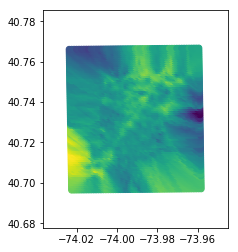

In [12]:
mgd_gdf[mgd_gdf.timestamp == mgd_gdf.timestamp.iloc[0]].plot('z')

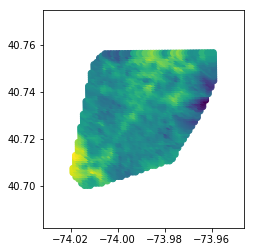

In [13]:
mgd_mn[mgd_mn.timestamp == mgd_gdf.timestamp.iloc[0]].plot('z')

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


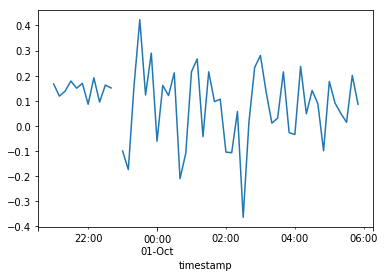

In [14]:
import numpy as np
mgd_mn.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot()

In [15]:
def fancy_plot(df):
    fig = plt.figure(figsize=(10,7),facecolor='w')
    ax = fig.add_subplot(111)
    lns1 = ax.plot(df['timestamp'].unique(),df.groupby('timestamp').z.mean(), '-o', label = 'Brightness',alpha=0.3)
    ax2 = ax.twinx()
    lns3 = ax2.plot(df['timestamp'].unique(),df.groupby('timestamp').dbzh.mean(), '-r.', label = 'DBZ',alpha=0.3)


    lns = lns1+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)


    fig.autofmt_xdate()
    #ax.grid()
    ax.set_title('Brightness and DBZ, {}'.format(night),fontsize=18)
    #ax.set_xlim('22017-09-30 19:00:33', '2017-10-01 07:51:52')
    #ax.set_xlim('2017-04-13 21:00:00', '2017-04-29 05:00:00')


    #ax.set_xlim('2017-04-14 21:00:00', '2017-04-15 05:00:00')
    #ax.set_xlim('2017-04-18 21:00:00', '2017-04-19 05:00:00')
    #ax.set_xlim('2017-04-23 21:00:00', '2017-04-24 05:00:00')
    #ax.set_xlim('2017-04-24 21:00:00', '2017-04-25 05:00:00')
    #ax.set_xlim('2017-04-27 21:00:00', '2017-04-28 05:00:00')

    #ax.set_ylim(0, 0.08)

    ax.set_xlabel("Time",fontsize=14)
    ax.set_ylabel("Brightness (log cd)",fontsize=14)
    ax2.set_ylabel("Reflectivity (dBZ)",fontsize=14)

    plt.show()

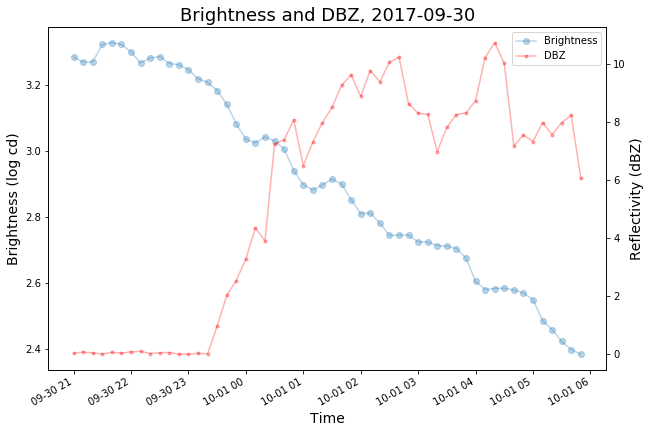

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
fancy_plot(mgd_mn)

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


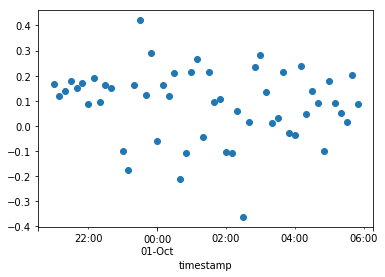

In [17]:
mgd_mn.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot(style='o')

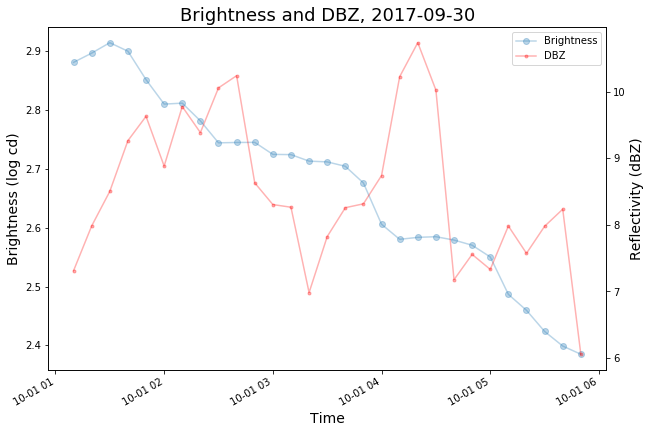

0.09686430253480492

In [18]:
after_begins = (mgd['timestamp'] > '{} 01:00:00'.format(next_night))
fancy_plot(mgd[after_begins])
np.corrcoef(mgd[after_begins]["dbzh"], mgd[after_begins]["z"])[0,1]

In [19]:
ma = mgd_mn[after_begins].groupby("timestamp")[["dbzh", "z"]].mean()
from sklearn.preprocessing import StandardScaler
dbz = StandardScaler().fit_transform(ma["dbzh"].values.reshape(-1, 1))
bgd = StandardScaler().fit_transform(ma["z"].values.reshape(-1, 1))
np.corrcoef(bgd[:, 0], dbz[:, 0])[1, 0]

0.3076564243689673

### Lower MN only

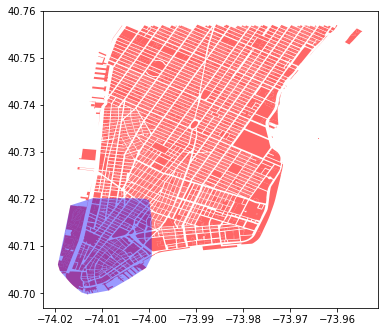

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(6, 11))

krige.in_frame.plot(ax=ax, color='red', alpha=.6)
filt = (krige.out_reset.geometry.centroid.x > -74.03) & (krige.out_reset.geometry.centroid.y > 40.7)
krige.out_reset[filt].plot(ax=ax, color='red', alpha=.6)

infilt = (krige.in_frame.geometry.centroid.y < 40.72) & (krige.in_frame.geometry.centroid.x < -74) 
outfilt2 = (krige.out_reset.geometry.centroid.y < 40.72) & (krige.out_reset.geometry.centroid.x < -74)
ch = gpd.GeoSeries(pd.concat([krige.in_frame[infilt].geometry, 
                              krige.out_reset[filt & outfilt2].geometry])).unary_union.convex_hull
gpd.GeoSeries([ch]).plot(ax=ax, color='blue', alpha=.4)
ch_df = gpd.GeoDataFrame({"geometry": gpd.GeoSeries([ch])})

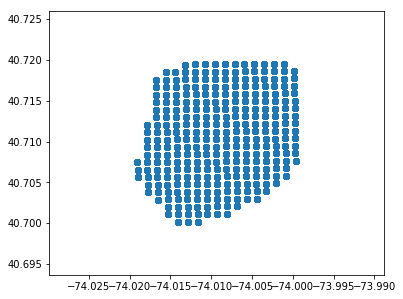

In [21]:
import shapely.geometry
mgd_mn["geometry"] = mgd_mn[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
mgd_mn = gpd.GeoDataFrame(mgd_mn)
if 'index_left' in mgd_mn:
    del mgd_mn["index_left"]
if 'index_right' in mgd_mn:
    del mgd_mn["index_right"]
joined = gpd.sjoin(mgd_mn, ch_df)
fig, ax = plt.subplots(1, 1, figsize=(6, 11))
joined.plot(ax=ax)

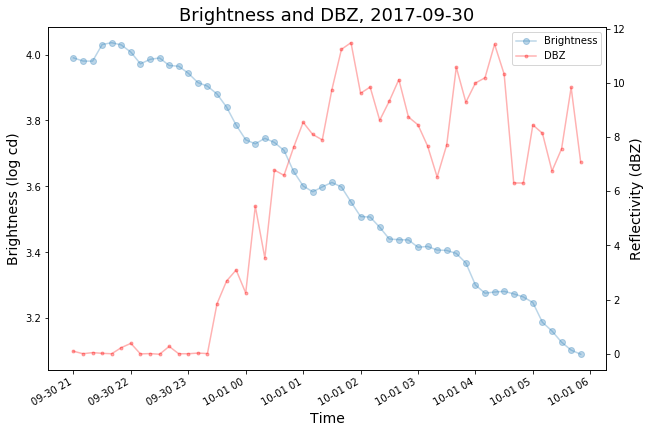

In [22]:
fancy_plot(joined)

In [23]:
after_begins = (joined['timestamp'] > '{} 01:00:00'.format(next_night))

ma = joined[after_begins].groupby("timestamp")[["dbzh", "z"]].mean()
from sklearn.preprocessing import StandardScaler
dbz = StandardScaler().fit_transform(ma["dbzh"].values.reshape(-1, 1))
bgd = StandardScaler().fit_transform(ma["z"].values.reshape(-1, 1))
np.corrcoef(bgd[:, 0], dbz[:, 0])[1, 0]

0.3260570853187169

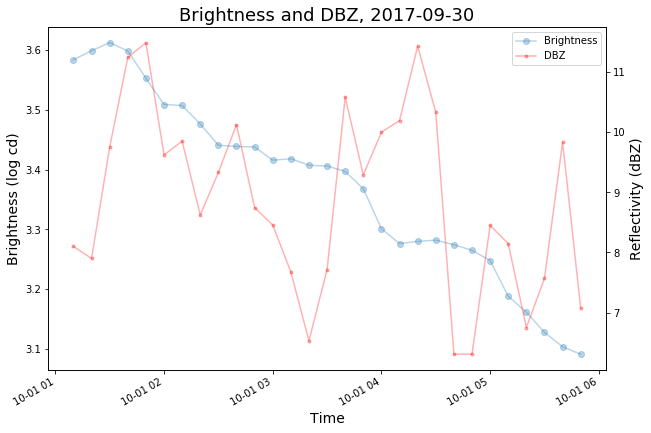

In [24]:
fancy_plot(joined[after_begins])

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


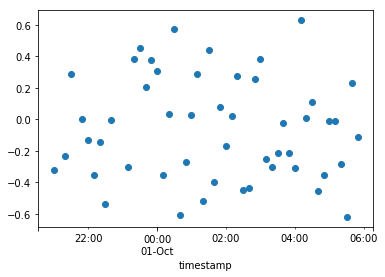

In [25]:
joined.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot(style='o')

### Diffs

In [26]:
mgd["zexp"] = np.exp(mgd["z"])
def get_diffs(g):
    std = g.sort_values("timestamp")
    diff_light = std["z"][1:].values - std["z"][:-1].values
    diff_light_exp = std["zexp"][1:].values - std["zexp"][:-1].values
    diff_dbzh = std["dbzh"][1:].values - std["dbzh"][:-1].values
    return pd.DataFrame({"light": diff_light, "dbzh": diff_dbzh, 
                         "ts": std["timestamp"][1:].values, 
                         "light_exp": diff_light_exp, 
                         "lat": std["lat"].values[1:],
                         "lon": std["lon"].values[1:]})
grouped = mgd.groupby(['x', 'y']).apply(get_diffs)
rst = grouped.reset_index()

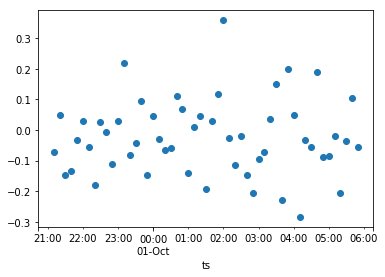

In [27]:
rst.groupby('ts').apply(lambda g: np.corrcoef(g["dbzh"], g["light"])[0, 1]).plot(style='o')

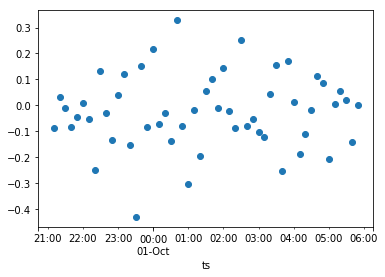

In [28]:
rst.groupby('ts').apply(lambda g: np.corrcoef(g["dbzh"], g["light_exp"])[0, 1]).plot(style='o')

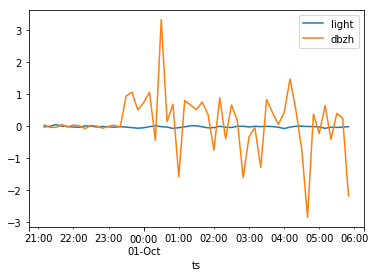

In [29]:
rst.groupby('ts')[["light", "dbzh"]].mean().plot()

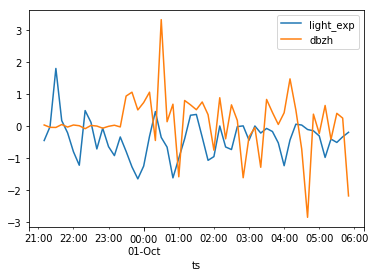

In [30]:
rst.groupby('ts')[["light_exp", "dbzh"]].mean().plot()

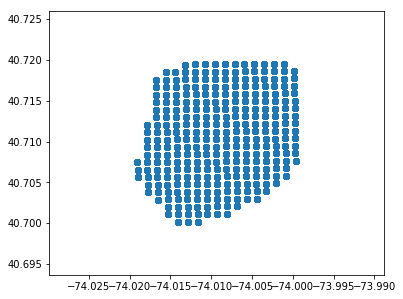

In [31]:
import shapely.geometry
rst["geometry"] = rst[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
rst = gpd.GeoDataFrame(rst)
if 'index_left' in rst:
    del rst["index_left"]
if 'index_right' in rst:
    del rst["index_right"]
joined = gpd.sjoin(rst, ch_df)
fig, ax = plt.subplots(1, 1, figsize=(6, 11))
joined.plot(ax=ax)

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


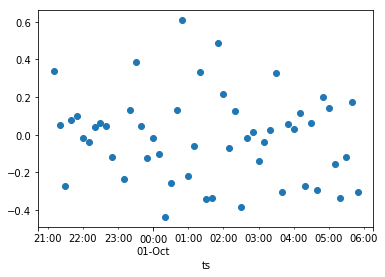

In [32]:
joined.groupby('ts').apply(lambda g: np.corrcoef(g["dbzh"], g["light"])[0, 1]).plot(style='o')

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


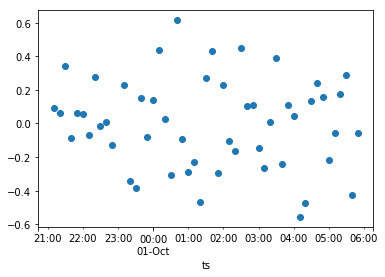

In [33]:
joined.groupby('ts').apply(lambda g: np.corrcoef(g["dbzh"], g["light_exp"])[0, 1]).plot(style='o')

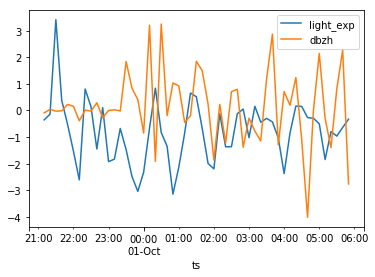

In [34]:
joined.groupby('ts')[["light_exp", "dbzh"]].mean().plot()

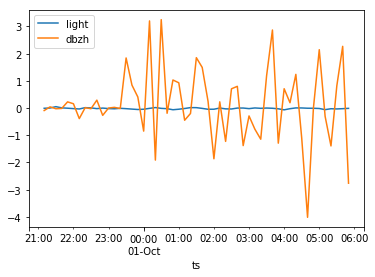

In [35]:
joined.groupby('ts')[["light", "dbzh"]].mean().plot()